In [1]:
#Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy.stats import linregress
%matplotlib inline

### Conversions and assumptions

In [2]:
#Conversions and assumptions
biogas_methane = 0.60
biogas_co2 = 0.4
TCF = 1
MMBtu = 1.037
days = 365
hours = days * 24

#Swine farm type lagoon yields
lagoon_yields = {'Swine - Feeder to Finish':[2336],
                 'Swine - Wean to Feeder':[420],
                 'Swine - Wean to Finish':[2068],
                 'Swine - Farrow to Wean':[1183],
                 'Swine - Farrow to Feeder':[1603]}

### Compute cost curve slope and intercept

In [3]:
#IMPORT THE DATA
#Swine Waste to Methane Cost Data
dfWasteToCost = pd.DataFrame({"Farm_type":"Swine",
                              "Digester":"Covered Lagoon",
                              "Biogas":[634,1226,6436],
                              "Methane":[23.7,13.7,5.2]
                             })
dfWasteToCost

,Farm_type,Digester,Biogas,Methane
0,Swine,Covered Lagoon,634,23.7
1,Swine,Covered Lagoon,1226,13.7
2,Swine,Covered Lagoon,6436,5.2


In [4]:
#OMPUTE THE CURVE FORMULA
#Set x to log of Biogas values
x = np.log(dfWasteToCost.Biogas)
#Set y to methand costs
y = dfWasteToCost.Methane
#Apply linear regression 
cost_curve_slope,cost_curve_intercept,r,p,str_err = linregress(x, y)
print("Cost curve slope = \t{0:.2f}".format(cost_curve_slope))
print("Cost curve intercept = \t{0:.2f}".format(cost_curve_intercept))
print("R-squared = \t\t{0:.4f}".format(r**2))
#Create the formula
fx = np.poly1d((cost_curve_slope,cost_curve_intercept))

Cost curve slope = 	-7.43
Cost curve intercept = 	69.51
R-squared = 		0.9179


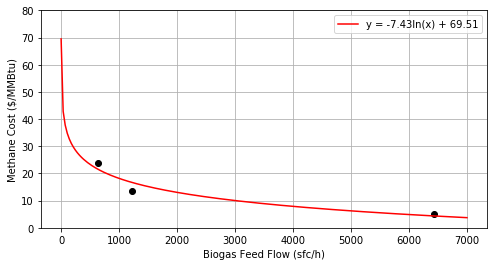

In [5]:
#PLOT THE CURVE
fx_txt = "y = {0:.2f}ln(x) + {1:.2f}".format(cost_curve_slope,cost_curve_intercept)
xp = np.log(np.linspace(1,7000,200))
plt.figure(figsize=(8,4))
plt.plot(np.exp(x), y, 'ko', label="")
plt.plot(np.exp(xp), fx(xp), 'r-', label=fx_txt)
plt.legend()
plt.ylim(0,80)
plt.xlabel("Biogas Feed Flow (sfc/h)")
plt.ylabel("Methane Cost ($/MMBtu)")
plt.grid()

In [6]:
#CREATE THE TABLE OF LAGOON BIOGAS PRODUCTION FOR EACH TIME
#Farm Type | Biogas (scf/year) | Methane (MMBtu/year)
dfYields = pd.DataFrame(lagoon_yields).T
dfYields.columns = ['Biogas_annual_yield']
#Compute Methand yield from biogas yield and convertion factor
dfYields['Methane_annual_yield'] = MMBtu * (dfYields['Biogas_annual_yield'] * biogas_methane)/1000
dfYields

,Biogas_annual_yield,Methane_annual_yield
Swine - Feeder to Finish,2336,1.453459
Swine - Wean to Feeder,420,0.261324
Swine - Wean to Finish,2068,1.286710
Swine - Farrow to Wean,1183,0.736063
Swine - Farrow to Feeder,1603,0.997387


### Compute values for each farm in the Excel worksheet

In [7]:
#Read in the data
dfDuplin = pd.read_excel('../data/DuplinCountySwineFarmEconomics.xlsx',
                         sheet_name='Duplin County Swine Farm Master').iloc[:,:13]
#Join the lagoon data
dfDuplin = dfDuplin.join(dfYields,on=['Regulated Activity'])

In [8]:
#Compute derived columns 
dfDuplin['Biogas_feed_flow_per_hour'] = (dfDuplin['Allowable Count'] * 
                                         dfDuplin['Biogas_annual_yield'] / 
                                         hours)
dfDuplin['Total_methane_yield'] = (dfDuplin['Allowable Count'] * 
                                   dfDuplin['Methane_annual_yield']) 
dfDuplin['Methane_production_cost'] = (cost_curve_slope * 
                                       np.log(dfDuplin['Biogas_feed_flow_per_hour']) + 
                                       cost_curve_intercept)
dfDuplin['Total_production_cost'] = dfDuplin['Total_methane_yield'] * dfDuplin['Methane_production_cost']

In [9]:
dfDuplin.iloc[:,9:].head()

,Admin Region,County Name,Farm Latitude,Farm Longitude,Biogas_annual_yield,Methane_annual_yield,Biogas_feed_flow_per_hour,Total_methane_yield,Methane_production_cost,Total_production_cost
0,Wilmington,Duplin,34.725000,-77.758300,2336,1.453459,2937.600000,16011.306547,10.181066,163012.164846
1,Wilmington,Duplin,34.727500,-77.960600,2336,1.453459,314.666667,1715.081856,26.777412,45925.453657
2,Wilmington,Duplin,34.730108,-77.772947,420,0.261324,124.657534,679.442400,33.656741,22867.816918
3,Wilmington,Duplin,34.731100,-77.732800,2336,1.453459,1536.000000,8371.924992,14.998459,125565.973452
4,Wilmington,Duplin,34.731900,-77.796400,2336,1.453459,2611.200000,14232.272486,11.056139,157353.979156


In [10]:
#Sort on Total Potential Methane Yield (MMBtu/y) - high to low
dfDuplin.sort_values('Total_methane_yield',ascending=False,inplace=True)
#Compute cumulative sum of Total Potential Methane Yield (MMBtu/y)
dfDuplin['Cumulative_methane_yield'] = dfDuplin['Total_methane_yield'].cumsum()
#Compute cumulative percentages
dfDuplin['Cumulative Percentage (%)'] = (dfDuplin['Cumulative_methane_yield'] / 
                                         dfDuplin['Cumulative_methane_yield'].max())

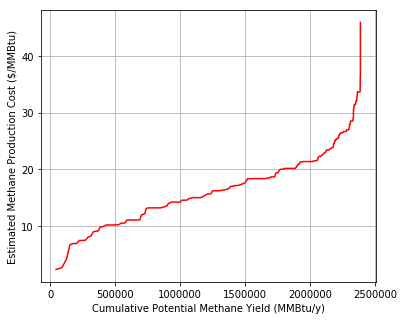

In [11]:
#Plot Cost vs Yield
x = dfDuplin['Cumulative_methane_yield']
y = dfDuplin['Methane_production_cost']
plt.figure(figsize=(6,5))
plt.plot(x,y,'r-')
plt.xlabel('Cumulative Potential Methane Yield (MMBtu/y)')
plt.ylabel('Estimated Methane Production Cost ($/MMBtu)')
plt.grid()
plt.show()

## Pipe Cost

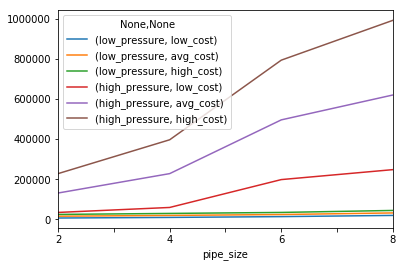

In [136]:
dfP = pd.DataFrame({'pipe_size':['2','4','6','8','Right of way'],
                    'lp_low_cost_per_mile':[6947,9924,13894,19848,11909],
                    'lp_avg_cost_per_mile':[15878,19848,24314,32252,34733],
                    'lp_high_cost_per_mile':[24809,29771,34733,44656,57556],
                    'hp_low_cost_per_mile':[34733,59541,198468,248085,11909],
                    'hp_avg_cost_per_mile':[131486,228238,496169,620211,34733],
                    'hp_high_cost_per_mile':[228238,396935,793870,992337,57556]}).set_index('pipe_size')
dfP.columns = pd.MultiIndex.from_product([['low_pressure','high_pressure'],
                            ['low_cost','avg_cost','high_cost']],
                           names=['pressure','cost']
                            )
df.iloc[:,:-1].T.plot()

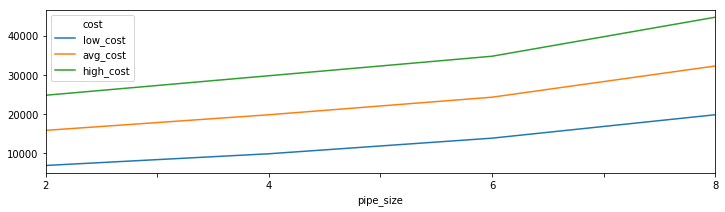

In [137]:
dfP['low_pressure'][:-1].plot(figsize=(12,3))

In [157]:
dfLP = dfP['low_pressure'][:-1]
dfHP = dfP['high_pressure'][:-1]

In [258]:
x = [2,4,6,8]
y = dfHP.avg_cost
#Log transform values
lx = np.log(x)
ly = np.log(y)
#Compute least squares on log data
slope,intercept,r,p,str_err = linregress(lx, ly)
power = np.exp(slope)
coeff = np.exp(intercept)
strFormula = "y = {0:.0f}x**({1:.4f}):  R2 ={2:.4f}".format(coeff,slope,r**2)
print(strFormula)

#Create the formula
fx = np.poly1d(power,coeff)
fz = np.poly1d(slope, coeff)

y = 54577x**(1.1676):  R2 =0.9651


In [243]:
def HPx(x):
    return coeff * x**slope

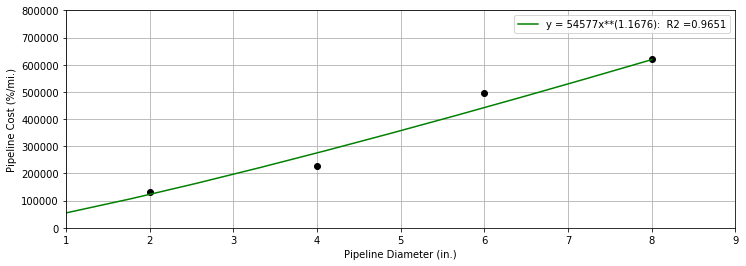

In [268]:
#PLOT THE CURVE
fx_txt = "y = {0:.2f}ln(x) + {1:.2f}".format(cost_curve_slope,cost_curve_intercept)
xp = np.linspace(1,8,10)
plt.figure(figsize=(12,4))
plt.plot(x, y, 'ko', label="")
plt.plot(xp,(Fx(xp)), 'g-', label=strFormula)
plt.legend()
plt.ylim(0,800000)
plt.xlim(1,9)
plt.ylabel("Pipeline Cost (%/mi.)")
plt.xlabel("Pipeline Diameter (in.)")
plt.grid()